In [1]:
%load_ext autoreload
%autoreload 1
print('autoreload')

import SimpleITK as sitk
import os, sys

print('simpleitk,os,sys')

sys.path.append('./workflow/libs/')
%aimport utils
%aimport config
%aimport segment 
%aimport match 
%aimport missingness 
%aimport register 
%aimport evaluate 
%aimport qc 

print('libs')

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sbn

print('other')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

pd.set_option('display.max_columns', None)
# May be necessary to "Trust" the notebook in order to get the widgets to work. 

please anything
zapatos
yabadabodoo


# Results Visualization 

Tool for interacting with results on exahead. 


## Overview

The file `aggregated_results.csv` is formed from three different sources: 
- each core-directory's parsed names: This contains the core name and the absolute path; This can be used to track and organize the data. **BUG** - currently R0 is not included in this dataset. 
- the original core segmentation stats: this will include the original file name and segmentation statistics. 
- registration results: This contains registration success metrics 

Because of this, there is substantial missingness between row observations depending on which source it came from. 

## Data Dictionary 



In [17]:
data_dict = pd.read_csv('./workflow/libs/data_dict.csv', sep='\t')
data_dict

name  \
0                                           status   
1                                             core   
2                                            round   
3                                    color_channel   
4                                             path   
5                                       center_x/y   
6                                     width/height   
7                                    volume (nm^3)   
8                                       Elongation   
9                                         Flatness   
10  Oriented Bounding Box Minimum/Maximum Size(nm)   
11                                  Intensity Mean   
12                    Intensity Standard Deviation   
13                              Intensity Skewness   
14                                       component   
15                                        img_name   
16                                         protein   
17                                      slide_name   
18                                            date   
19                                         scan_id   
20                                           scene   
21                                            note   
22                                       file_type   
23                                        original   
24                                         cluster   
25                                            name   
26                                    jacaard_coef   
27                                       dice_coef   
28                               volume_similarity   
29                                   false_neg_err   
30                                   false_pos_err   
31                                  hausdorff_dist   
32                                 registered_path   

                                                  def  
0   whether the core has been registered or not. N...  
1   core identifier, this is the core cluster labe...  
2   The image round identifier, should be in forma...  
3   fluorescence wavelength measured. c1 is always...  
4                    *local path* or core file name.   
5   core segmentation center x/y coordinate, in re...  
6   core segmentation width/height (potentitally d...  
7                                                 ...  
8                                                 ...  
9                                                ...   
10                                                ...  
11                                                ...  
12                                               ...   
13                                                ...  
14  *why isn't this the same as `core` - aren't th...  
15                   original scan-scene image name    
16                                                ...  
17                                                ...  
18                                                ...  
19                                              ...    
20                                               ...   
21                                               ...   
22                                                ...  
23                          duplicate of `img_name`    
24                                              ...    
25                               duplicate of `path`   
26                                              ...    
27                                                ...  
28                                                ...  
29                                               ...   
30                                              ...    
31                                               ...   
32  absolute path to this image, can be used for a...

# Read registration results into memory

In [18]:
res = pd.read_csv('/home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output/aggregated_results.csv')

# drop unnecessary columns 
res = res.drop(['Unnamed: 0', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)

# select only registered results -- keep R0 unregistered as this is the aligned reference 
res = res[(res.status == 'registered') | (res.round == 'R0')]

res.head()

status  core round color_channel  \
2   registered    56    R1            c1   
3   registered    56    R2            c3   
6   registered    56    R1            c4   
10  registered    56    R2            c5   
16  registered    56    R1            c5   

                                        path  center_x  center_y  width  \
2   registered_core=56_round=R1_color=c1.tif    1079.0    1124.0  122.0   
3   registered_core=56_round=R2_color=c3.tif       NaN       NaN    NaN   
6   registered_core=56_round=R1_color=c4.tif       NaN       NaN    NaN   
10  registered_core=56_round=R2_color=c5.tif       NaN       NaN    NaN   
16  registered_core=56_round=R1_color=c5.tif       NaN       NaN    NaN   

    height  Volume (nm^3)  Elongation  Flatness  \
2    117.0       0.470113    1.039698  1.039698   
3      NaN            NaN         NaN       NaN   
6      NaN            NaN         NaN       NaN   
10     NaN            NaN         NaN       NaN   
16     NaN            NaN         NaN       NaN   

    Oriented Bounding Box Minimum Size(nm)  \
2                                 0.771342   
3                                      NaN   
6                                      NaN   
10                                     NaN   
16                                     NaN   

    Oriented Bounding Box Maximum Size(nm)  Intensity Mean  \
2                                 0.799247       14.819089   
3                                      NaN             NaN   
6                                      NaN             NaN   
10                                     NaN             NaN   
16                                     NaN             NaN   

    Intensity Standard Deviation  Intensity Skewness  component  \
2                      14.666503             1.53097       55.0   
3                            NaN                 NaN        NaN   
6                            NaN                 NaN        NaN   
10                           NaN                 NaN        NaN   
16                           NaN                 NaN        NaN   

                                             img_name  \
2   R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...   
3                                                 NaN   
6                                                 NaN   
10                                                NaN   
16                                                NaN   

                      protein slide_name        date  scan_id    scene note  \
2   H3K27me3.CCNB1.CCND1.Ki67         S3  2020-01-22  13485.0  Scene-1  ORG   
3                         NaN        NaN         NaN      NaN      NaN  NaN   
6                         NaN        NaN         NaN      NaN      NaN  NaN   
10                        NaN        NaN         NaN      NaN      NaN  NaN   
16                        NaN        NaN         NaN      NaN      NaN  NaN   

   file_type                                           original  cluster  \
2        tif  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...     56.0   
3        NaN                                                NaN      NaN   
6        NaN                                                NaN      NaN   
10       NaN                                                NaN      NaN   
16       NaN                                                NaN      NaN   

                                        name  jacaard_coef  dice_coef  \
2   registered_core=56_round=R1_color=c1.tif      0.760846   0.864182   
3                                        NaN           NaN        NaN   
6                                        NaN           NaN        NaN   
10                                       NaN           NaN        NaN   
16                                       NaN           NaN        NaN   

    volume_similarity  false_neg_err  false_pos_err  hausdorff_dist  \
2             -0.0374       0.151681       0.119349         0.09009   
3                 NaN            NaN            NaN             NaN   
6    

## Available experiments 

why isn't `R0` available here? [Issue #7](https://github.com/nathanieljevans/cyclicIF_registration/issues/7)

### Choose experiment from drop down menu

In [30]:
options = res[['slide_name', 'scene']].drop_duplicates().dropna()

opt = [f'{x.slide_name} - {x.scene}' for i,x in options.iterrows()]
_exp = widgets.Dropdown(
    options=opt,
    value=opt[0],
    description='Experiment',
    disabled=False,
)
_exp

Dropdown(description='Experiment', options=('S3 - Scene-1',), value='S3 - Scene-1')

### filter the aggregated results 

In [31]:
SLIDE, SCENE = _exp.value.split(' - ')
res = res[(res.slide_name == SLIDE) & (res.scene == SCENE)]

## Registration results 

# Registration Results 

Why is there such clear separation between rounds? 
- something to do with lost material? I guess we would expect later rounds to register more poorly... 

Note: R1 has better metrics than R2. 

In [33]:
# select only the DAPI results
regRes = res[res.color_channel == 'c1']
vizRes = regRes[['round',*'jacaard_coef,dice_coef,volume_similarity,false_neg_err,false_pos_err,hausdorff_dist'.split(',')]]

vizRes.describe()

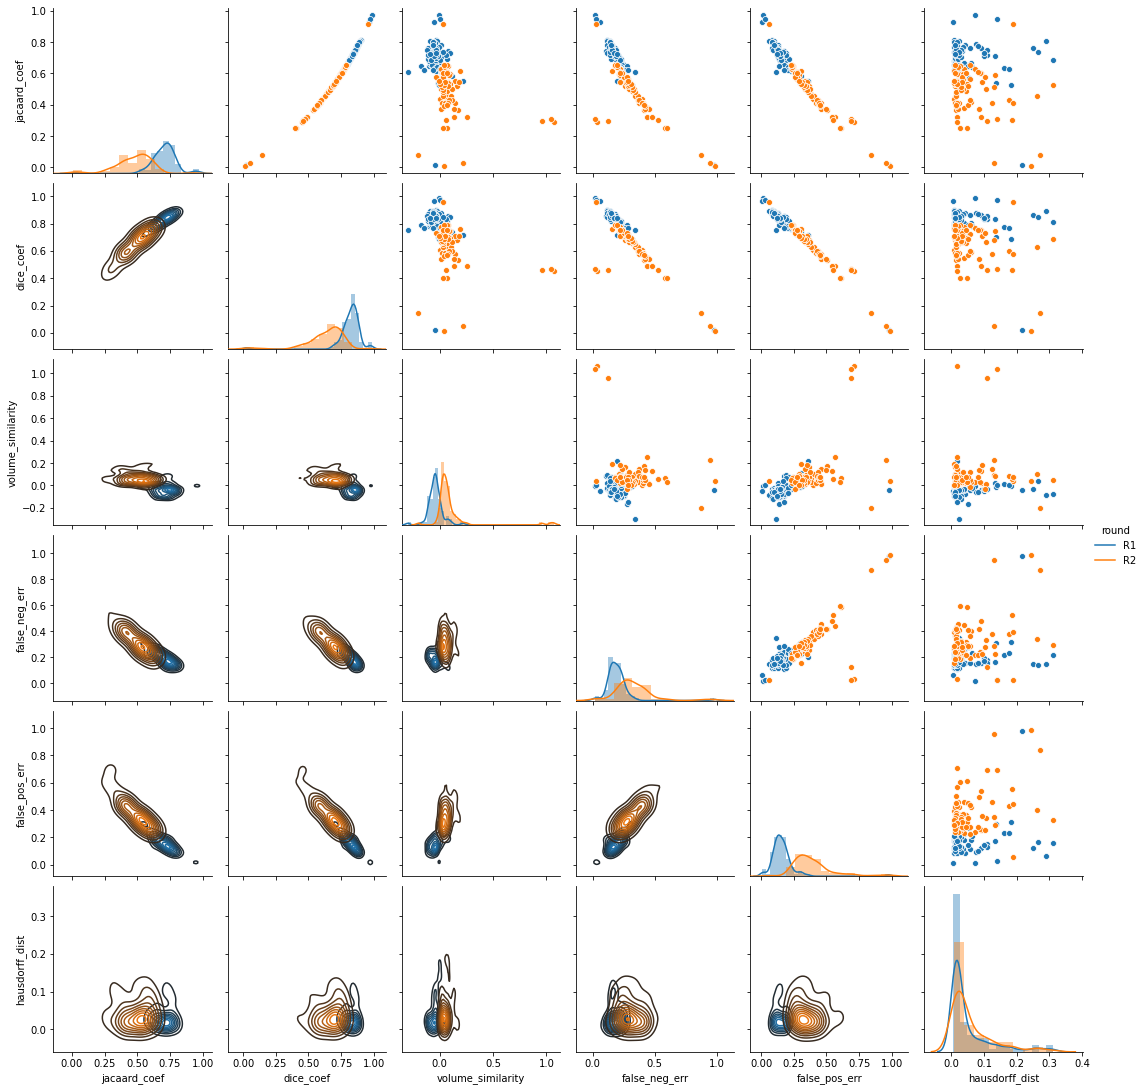

In [35]:
g = sbn.PairGrid(vizRes, hue='round')
g.map_upper(sbn.scatterplot)
g.map_diag(sbn.distplot)
g.map_lower(sbn.kdeplot)
g.add_legend()

## Manual thresholding 

We'll just use rational thresholds for now. Need further verification and tuning. 

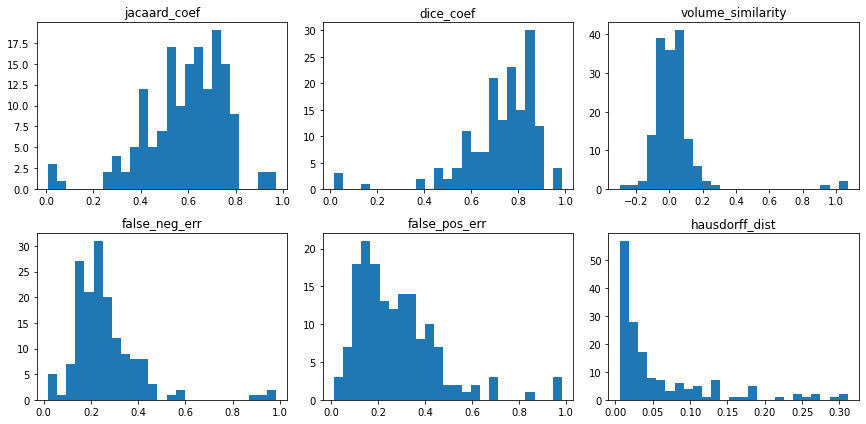

In [42]:
# higher is better 

f, axes = plt.subplots(2,3, figsize=(12,6))

for name,ax in zip(vizRes.columns.values[1:], axes.flat): 
    ax.hist(vizRes[name], bins=25)
    ax.set_title(name)

plt.tight_layout()
plt.show()

In [43]:
outRes = regRes[lambda x: (x.false_pos_err > config.FPR_threshold) | (x.false_neg_err > config.FNR_threshold) | (x.hausdorff_dist > config.hausdorff_distance_threshold)]

print(f'number of outliers: {outRes.shape[0]}/{regRes.shape[0]} [{100*outRes.shape[0]/regRes.shape[0]:.1f}%]')

number of outliers: 19
number of outliers: 19/159 [11.9%]


## inspect possible outliers

##################################################
registered_core=73_round=R2_color=c1.tif
##################################################
jacaard: 0.3225422074193178
dice: 0.4877609283240884
volume similarity: 0.2562009487315871
FPR: 0.5676263423270852
FNR: 0.4405766788675581
hausdorff dist: 0.017160402028433188


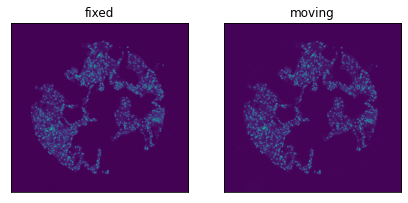

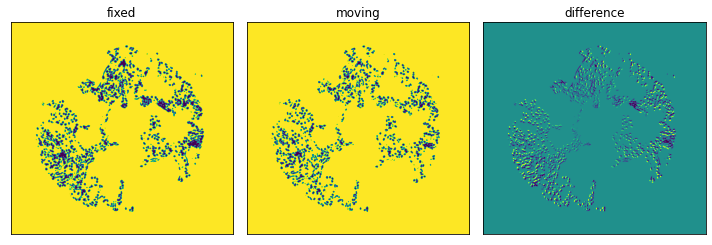

##################################################
registered_core=33_round=R2_color=c1.tif
##################################################
jacaard: 0.07735049299628452
dice: 0.14359392509518493
volume similarity: -0.19986944791617933
FPR: 0.8404627654044742
FNR: 0.8694523211536903
hausdorff dist: 0.27181983305186985


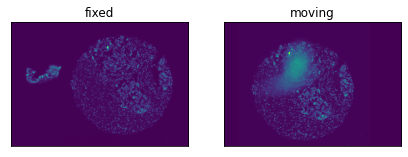

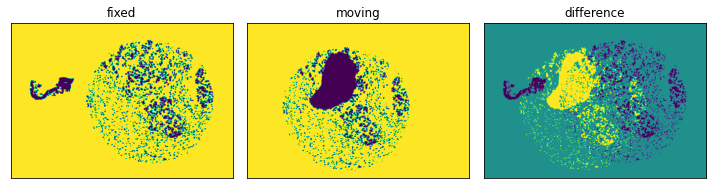

##################################################
registered_core=1_round=R2_color=c1.tif
##################################################
jacaard: 0.3233540233855156
dice: 0.4886886164569692
volume similarity: 0.13095872323765806
FPR: 0.5413438926545857
FNR: 0.4770702792572854
hausdorff dist: 0.09155727273817067


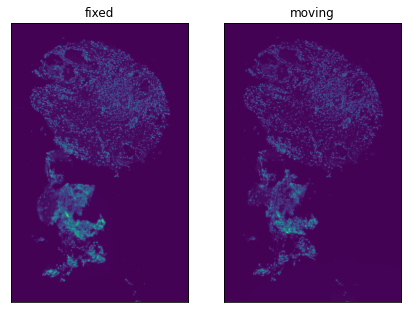

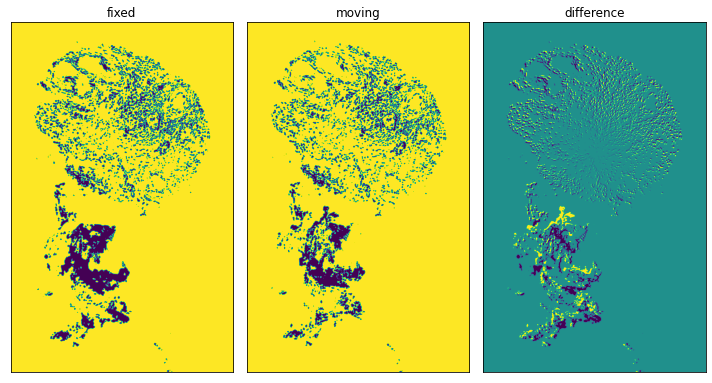

##################################################
registered_core=26_round=R1_color=c1.tif
##################################################
jacaard: 0.8088857478225974
dice: 0.8943469744247522
volume similarity: -0.08926387777307485
FPR: 0.06387180938160296
FNR: 0.14386403370164305
hausdorff dist: 0.2895601608052865


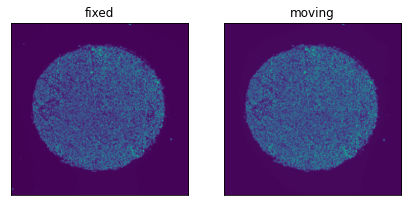

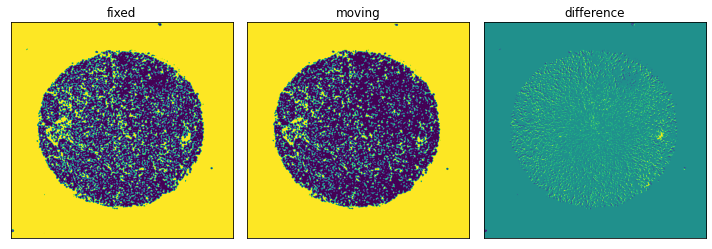

##################################################
registered_core=26_round=R2_color=c1.tif
##################################################
jacaard: 0.4574545534098464
dice: 0.6277445184682983
volume similarity: 0.10437780351795377
FPR: 0.4033918078599021
FNR: 0.3376902637737775
hausdorff dist: 0.2615959653579342


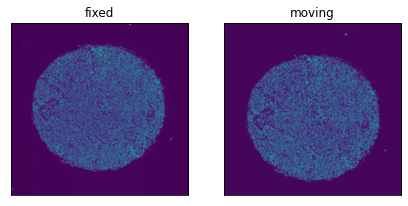

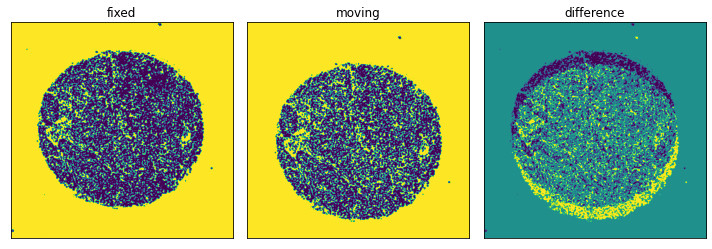

##################################################
registered_core=27_round=R2_color=c1.tif
##################################################
jacaard: 0.25189030805384305
dice: 0.40241594081102094
volume similarity: 0.06955647536541497
FPR: 0.6111090027248783
FNR: 0.5830844718576322
hausdorff dist: 0.04914679088866152


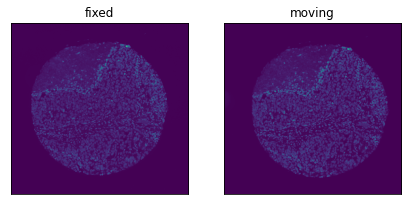

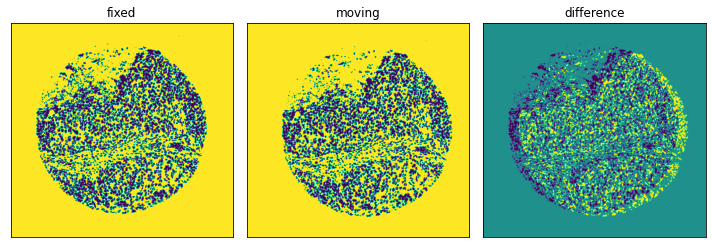

##################################################
registered_core=67_round=R2_color=c1.tif
##################################################
jacaard: 0.36675691012697137
dice: 0.5366819913760666
volume similarity: 0.17063624214482498
FPR: 0.5055072047946952
FNR: 0.4132583100855832
hausdorff dist: 0.015734751088550342


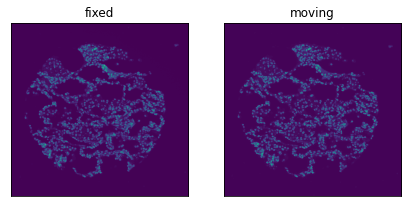

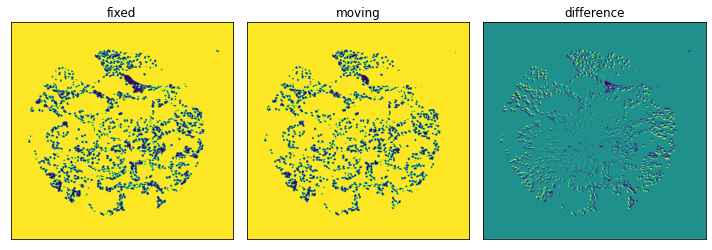

##################################################
registered_core=52_round=R2_color=c1.tif
##################################################
jacaard: 0.2899696778897137
dice: 0.4495759595901211
volume similarity: 1.0702645074484038
FPR: 0.7071418710020206
FNR: 0.03289491862617778
hausdorff dist: 0.017160402028433268


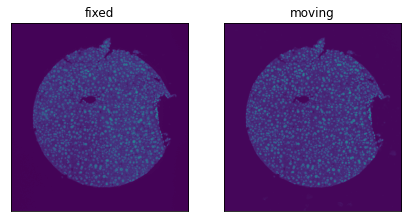

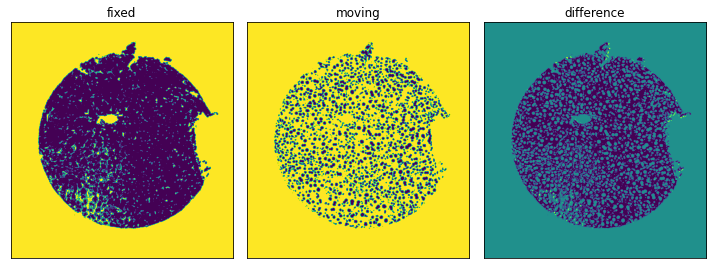

##################################################
registered_core=28_round=R2_color=c1.tif
##################################################
jacaard: 0.2988873911554749
dice: 0.4602206368168501
volume similarity: 0.05809346476329037
FPR: 0.5527699351887482
FNR: 0.5260115474499382
hausdorff dist: 0.18504821470463584


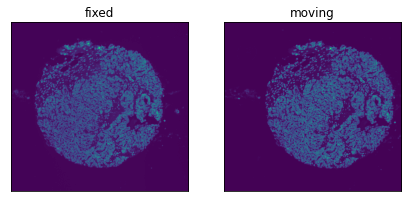

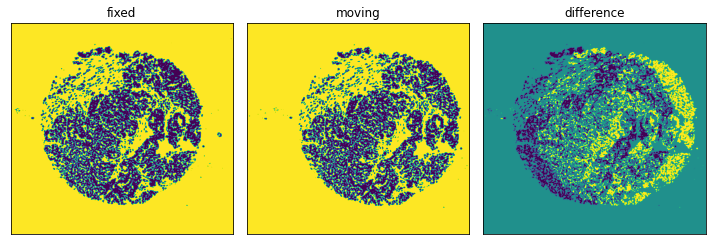

##################################################
registered_core=28_round=R1_color=c1.tif
##################################################
jacaard: 0.7586662295696155
dice: 0.8627745467714789
volume similarity: -0.02912592403229586
FPR: 0.12447521910007912
FNR: 0.14960965551416705
hausdorff dist: 0.24958260412985345


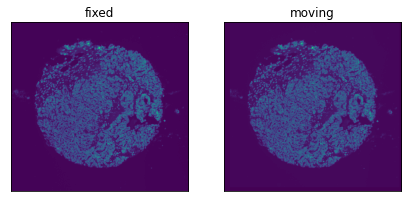

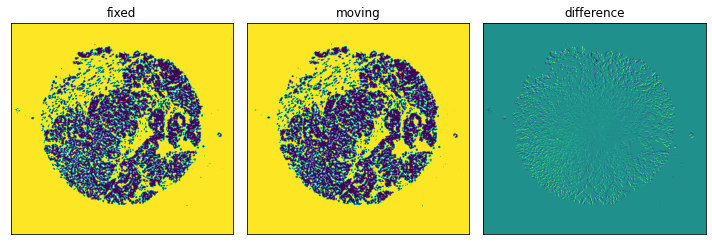

##################################################
registered_core=7_round=R1_color=c1.tif
##################################################
jacaard: 0.011837729648061185
dice: 0.02339847448103877
volume similarity: -0.045242181907745364
FPR: 0.976059976059976
FNR: 0.9771191160753264
hausdorff dist: 0.21561474961006705


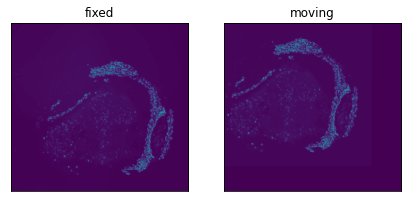

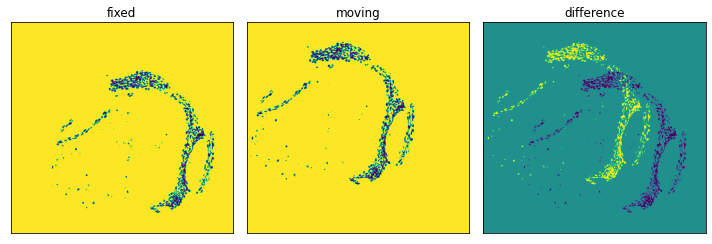

##################################################
registered_core=7_round=R2_color=c1.tif
##################################################
jacaard: 0.008540844522595964
dice: 0.016937032484071315
volume similarity: 0.04054282064261094
FPR: 0.9833994833994834
FNR: 0.9827125260378226
hausdorff dist: 0.2450625019010176


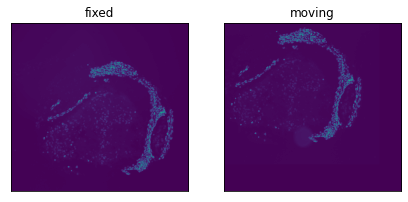

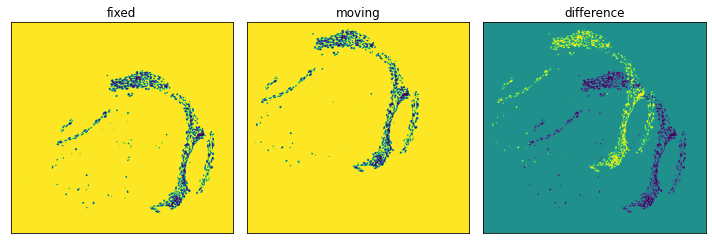

##################################################
registered_core=78_round=R2_color=c1.tif
##################################################
jacaard: 0.02603541153087096
dice: 0.05074953795605448
volume similarity: 0.22260250530494904
FPR: 0.9543332306744688
FNR: 0.942894554417315
hausdorff dist: 0.13175704770598715


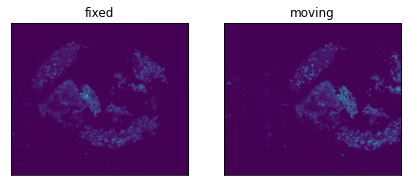

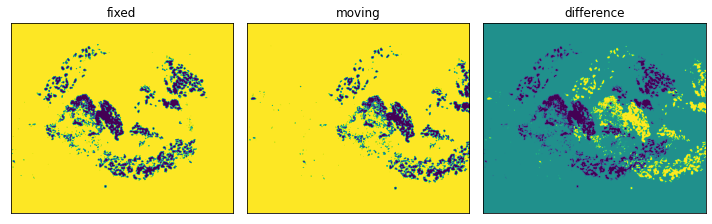

##################################################
registered_core=70_round=R2_color=c1.tif
##################################################
jacaard: 0.2497803608839629
dice: 0.3997188125236576
volume similarity: 0.028010598604877517
FPR: 0.60580204778157
FNR: 0.5946034879894703
hausdorff dist: 0.02632285510070737


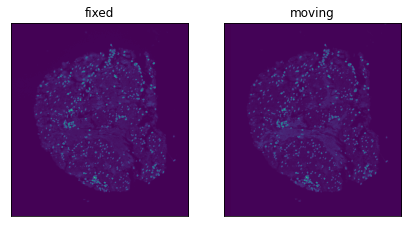

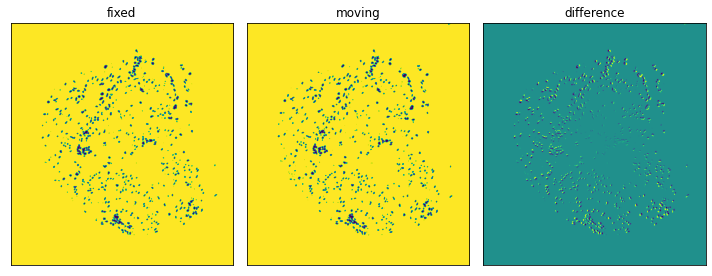

##################################################
registered_core=63_round=R2_color=c1.tif
##################################################
jacaard: 0.5242124699365507
dice: 0.6878469770797406
volume similarity: 0.04528496969556679
FPR: 0.3273827488380516
FNR: 0.2962176415325223
hausdorff dist: 0.3107500325345943


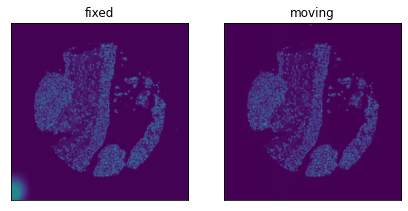

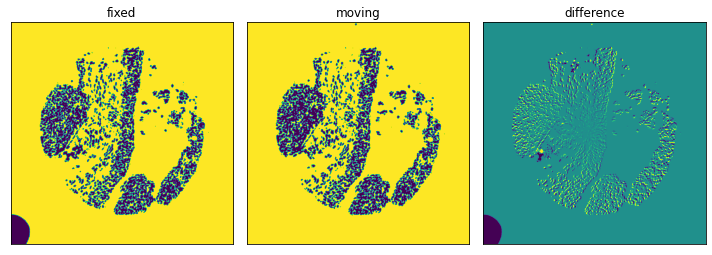

##################################################
registered_core=63_round=R1_color=c1.tif
##################################################
jacaard: 0.6817097433678739
dice: 0.8107341306147738
volume similarity: -0.07904572622241869
FPR: 0.155904810768395
FNR: 0.2200901400202868
hausdorff dist: 0.3112832178681603


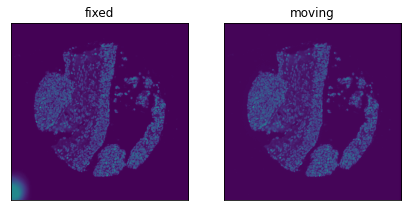

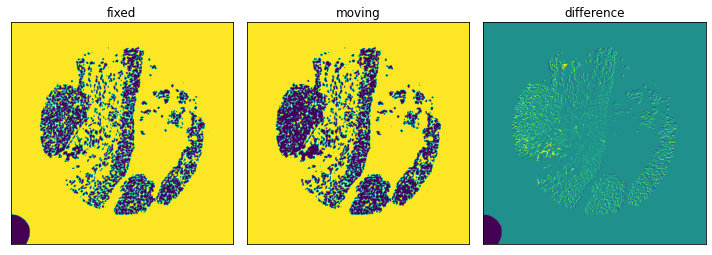

##################################################
registered_core=54_round=R1_color=c1.tif
##################################################
jacaard: 0.7356008202323991
dice: 0.8476612959123876
volume similarity: 0.03703867069105665
FPR: 0.1677513950927381
FNR: 0.13634437596302004
hausdorff dist: 0.2650687313206587


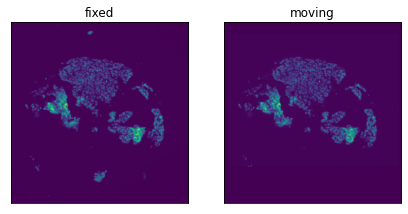

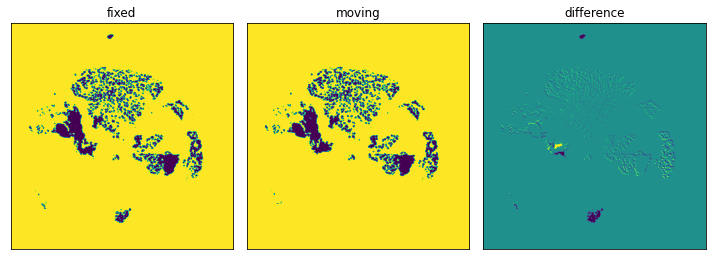

##################################################
registered_core=71_round=R2_color=c1.tif
##################################################
jacaard: 0.3069242069321476
dice: 0.4696893749525329
volume similarity: 1.0388361476080774
FPR: 0.6908754851279272
FNR: 0.022665336854526045
hausdorff dist: 0.13939206509401006


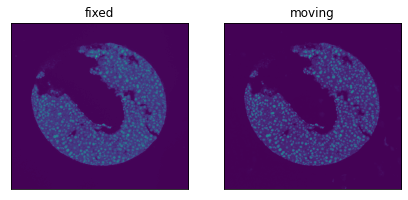

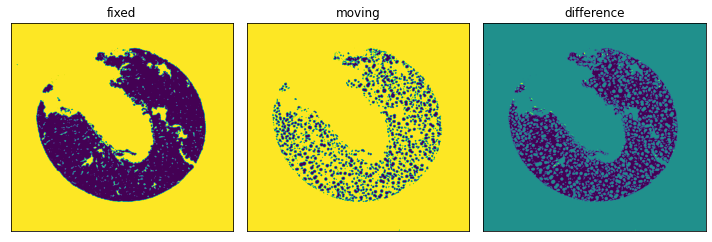

##################################################
registered_core=43_round=R2_color=c1.tif
##################################################
jacaard: 0.29562093037440096
dice: 0.4563386148585514
volume similarity: 0.9607772929128084
FPR: 0.6917440457606279
FNR: 0.1217693536785579
hausdorff dist: 0.10846376614739577


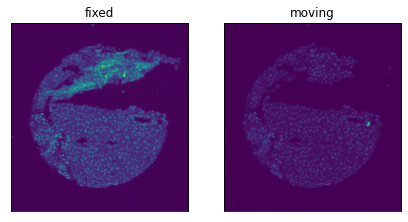

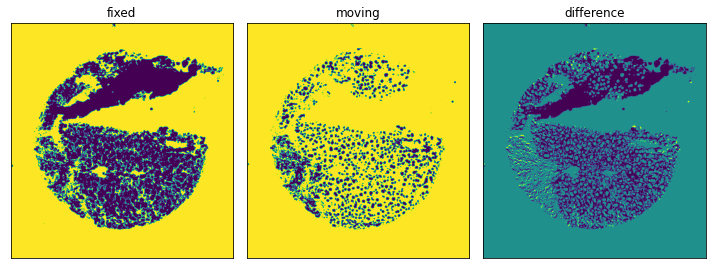

In [46]:
# for each core 
for i, row in outRes.iterrows(): 
    print('#'*50)
    print(row['name'])
    print('#'*50)
    print('jacaard:', row.jacaard_coef)
    print('dice:', row.dice_coef)
    print('volume similarity:', row.volume_similarity)
    print('FPR:', row.false_pos_err)
    print('FNR:', row.false_neg_err)
    print('hausdorff dist:', row.hausdorff_dist)
    img = sitk.ReadImage(row.registered_path)
    #utils.myshow(img)
    
    R0_dapi_path = f'{"/".join(row.registered_path.split("/")[:-1])}/unregistered_core={int(row.cluster)}_round=R0_color=c1.tif'
    
    R0_img = sitk.ReadImage(R0_dapi_path)
    #utils.myshow(img)
    
    f, axes = plt.subplots(1,2, figsize=(7,14))
    utils.myshow(R0_img, title='fixed', ax=axes[0])
    utils.myshow(img, title='moving', ax=axes[1])
    
    evaluate.plot_registration(R0_img, img)


# Registration Visualization

Build in some interactive widgets to visualize mapping. eg scroll select for which core(1) and round(R0 + 2) to include. 

Just a convenient way to pan through and visualize images. 

In [ ]:
def f(core): 
    '''
    '''
    core_dir = f'/home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output/S3/Scene-1/core-{"0"*(3-len(str(core)))}{core}'
    
    try:
        round0 = sitk.ReadImage(core_dir + f'/unregistered_core={core}_round=R0_color=c1.tif')
        round1 = sitk.ReadImage(core_dir + f'/registered_core={core}_round=R1_color=c1.tif')
        round2 = sitk.ReadImage(core_dir + f'/registered_core={core}_round=R2_color=c1.tif')

        sigm1 = sitk.Cast(sitk.RescaleIntensity(round0), sitk.sitkUInt8)
        sigm2 = sitk.Cast(sitk.RescaleIntensity(round1), sitk.sitkUInt8)
        sigm3 = sitk.Cast(sitk.RescaleIntensity(round2), sitk.sitkUInt8)

        cimg = sitk.Compose(sigm1, sigm2, sigm3)

        utils.myshow(cimg, figsize=(10,10))
        
        wsize = 100
        x,y = cimg.GetSize()
        utils.myshow(cimg[int(x/2-wsize):int(x/2+wsize), int(y/2-wsize):int(y/2+wsize)], figsize=(10,10))
    except:
        print('error loading images - there may be one missing?')

interact(f, core=regRes.core.unique().sort())